# DSCI100 Final Group Project

## Data Description:

The datasets given are these two files: players.csv and sessions.csv.

players.csv contains 197 observations of:
experience: Player’s chosen experience level, such as Pro, Veteran, Amateur, etc.
subscribe: Indicates if the player has subscribed to the email notification (True/False).
played_hours: Total hours played by the player.
gender: Gender of the player.
age: Age of the player.

sessions.csv contains 1536 (and counting) observations of:
hashedEmail: Anonymized identifier linking sessions to players.
start_time and end_time: Start and end times of each play session.
original_start_time and original_end_time: Timestamps for each session's start and end.

We plan to combine the information given from both files to calculate player metrics like session frequency, average session length, total playtime and time of day or day of week patterns. There is missing data in players.csv (individualId, organizationName) and there are outliers and inconsistencies in session.csv which will be addressed through data preprocessing, like standardizing the time formats.

## Question:

Question: "What time windows are most likely to have large number of simultaneous players>"

The goal is to predict the time window when the demand for concurrent player licenses is based on past patterns. We can analyze the hour of the day as well as the day of the week that most players get on, to help forecast player demand in each time window. This can help the research team manage the licenses and server capacity effectively during peak hours.

The predictors are:

Hour of the day, Day of the week, Weekend or Weekday


We will standardize all the time variables so that it can be easily plotted and analyzed.


## Exploratory Data Analysis and Visualization

To gain insight into player demand patterns, we’ll:

Aggregate data to determine the number of simultaneous players for each hourly window.
Visualize how player counts vary by hour of the day and day of the week.


In [55]:
library(tidyverse)

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
download.file(players_url, destfile = "players.csv", mode = "wb")
download.file(sessions_url, destfile = "sessions.csv", mode = "wb")

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

head(players)
head(sessions)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [56]:
#format data to date month year hour minute
merged_data <- sessions %>%
  mutate(
    start_datetime = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    end_datetime = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")
  )
head(merged_data)
#make new df to show time windows
#standardaize start times to within the same hour
#count simul players during said time
time_windows <- merged_data %>%
  mutate(hour = format(start_datetime, "%Y-%m-%d %H:00:00")) %>%
  group_by(hour) %>%
  summarise(simultaneous_players = n())
head(time_windows)

#convert back to time format for plotting
time_windows <- time_windows %>%
  mutate(hour = as.POSIXct(hour, format = "%Y-%m-%d %H:%M:%S"))
head(time_windows)

hashedEmail,start_time,end_time,original_start_time,original_end_time,start_datetime,end_datetime
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,2024-06-23 15:08:00,2024-06-23 17:10:00


hour,simultaneous_players
<chr>,<int>
2024-04-06 09:00:00,2
2024-04-06 20:00:00,1
2024-04-06 22:00:00,1
2024-04-07 00:00:00,1
2024-04-07 02:00:00,1
2024-04-07 05:00:00,2


hour,simultaneous_players
<dttm>,<int>
2024-04-06 09:00:00,2
2024-04-06 20:00:00,1
2024-04-06 22:00:00,1
2024-04-07 00:00:00,1
2024-04-07 02:00:00,1
2024-04-07 05:00:00,2


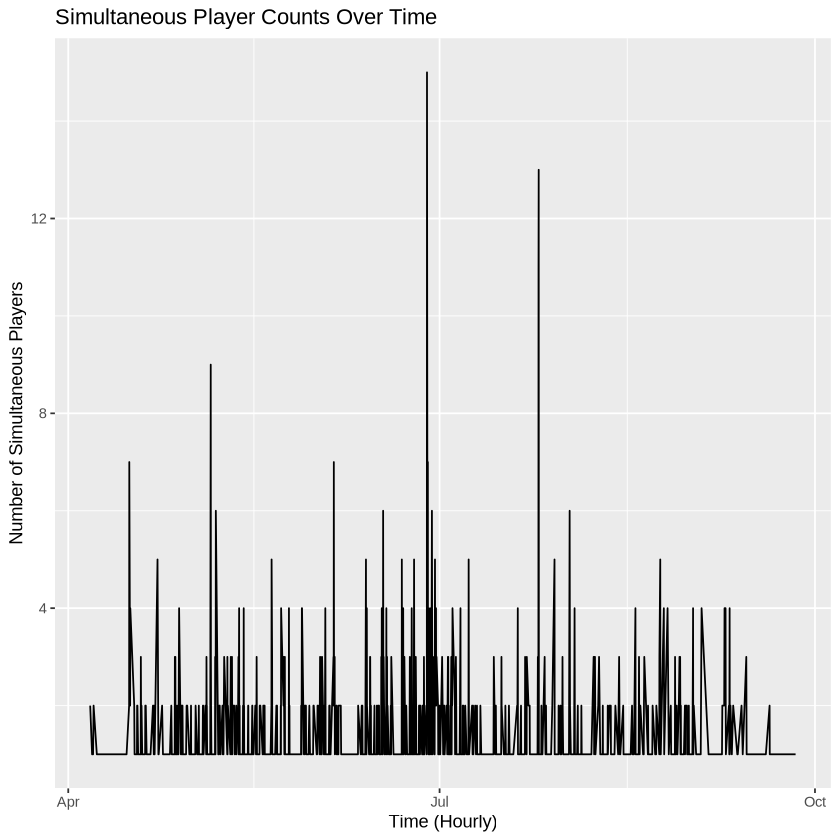

In [57]:
ggplot(time_windows, aes(x = hour, y = simultaneous_players)) +
  geom_line() +
  labs(
    title = "Simultaneous Player Counts Over Time",
    x = "Time (Hourly)",
    y = "Number of Simultaneous Players"
  )


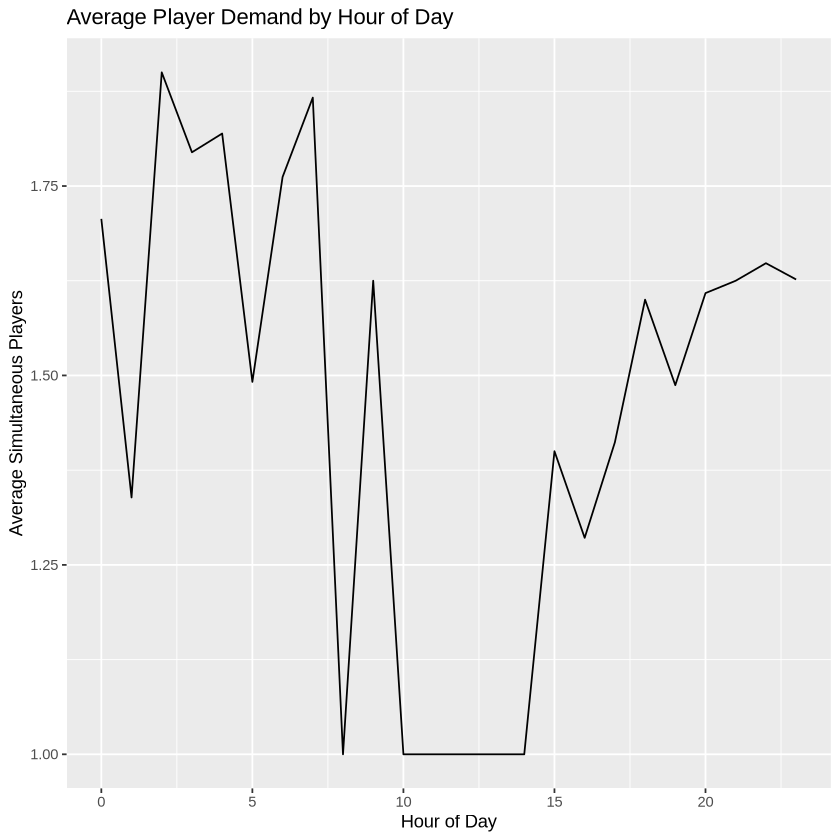

In [58]:
#add hour of day 
time_windows <- time_windows %>%
  mutate(hour_of_day = as.integer(format(hour, "%H")))

#calculte simul players during time of day (24 hr format)
avg_demand_by_hour <- time_windows %>%
  group_by(hour_of_day) %>%
  summarise(avg_players = mean(simultaneous_players, na.rm = TRUE))

# avg simul player vs hour of day
ggplot(avg_demand_by_hour, aes(x = hour_of_day, y = avg_players)) +
  geom_line() +
  labs(
    title = "Average Player Demand by Hour of Day",
    x = "Hour of Day",
    y = "Average Simultaneous Players"
  )



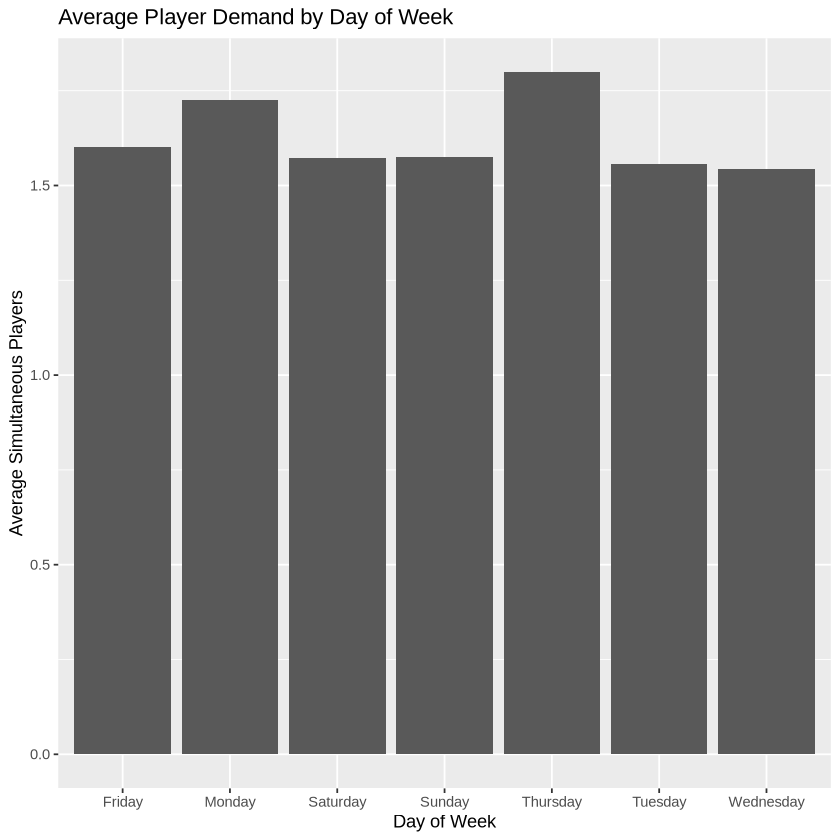

In [59]:
#add day of week
time_windows <- time_windows %>%
  mutate(day_of_week = weekdays(hour))
# count avg player simultaneous count
avg_demand_by_day <- time_windows %>%
  group_by(day_of_week) %>%
  summarise(avg_players = mean(simultaneous_players, na.rm = TRUE))

#plot average simul players vs day of week
ggplot(avg_demand_by_day, aes(x = day_of_week, y = avg_players)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Average Player Demand by Day of Week",
    x = "Day of Week",
    y = "Average Simultaneous Players"
  )


## Methods and Plan

We are using linear regression as an appropriate method because of the nature of the problem. This method can capture trends and patterns based on time-related variables like hour of the day and day of the week. It is also easily interpreted and allows see the demand for licenses. Using this model can allow us to predict the expected player count in each time window. We are assuming a linear relationship between our predictors and response variable so that this model can work. We assume that the player count i0n one hour is independent of player counts in other hours. The limitation of this model and plan is the possible sudden spikes in player counts that can occur at any time(As seen in Simultaneous Player Counts over Time). The data may also be showing the same player over different time windows. This means that if there is an average of 1 player count but its all different people then different licenses are still required, but the model doesn't know that. We may test the model accuracy using RMSE on the training set, and RMSPE on the test set. We will split the data to 70% training, and use the later/ more recent data periods to test. We will use K-Fold Cross Validation on the training set. We can use this plan to forecast peak demand times and allow to accomodate all parallel players. This approach offers a clear and understandable solution, while also being flexible on tweaking it based on how well it performs.

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


hashedEmail,x
<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


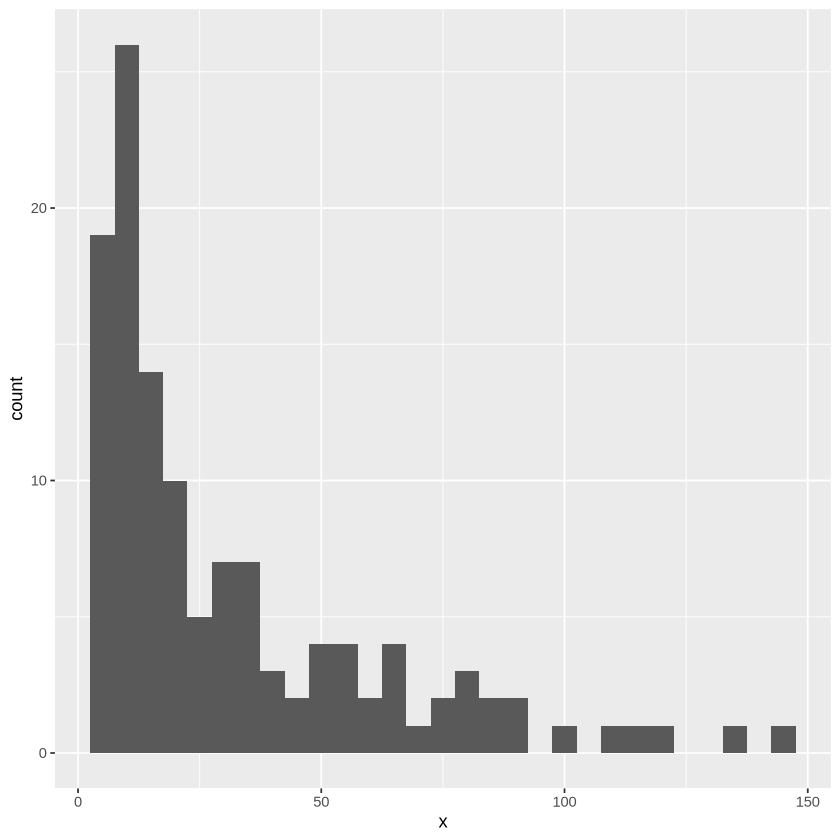

In [60]:
head(sessions)
time_played <- sessions |>
  mutate(start_time = dmy_hm(start_time),end_time = dmy_hm(end_time) )|>
  mutate(time_played = as.numeric(difftime(end_time, start_time, units = "mins")))|>
  group_by(hashedEmail)|>
  summarize(x=mean(time_played))
head(time_played)
time_played_plot<-time_played|>
    ggplot(aes(x=x))+
    geom_histogram(binwidth=5)
time_played_plot

The histogram shows a pronounced right-skewed distribution. This pattern indicates that the majority of players exhibit relatively short average playtimes, while the frequency of players steadily diminishes as the duration of playtime extends. In other words, there's a concentration of players with brief gaming sessions, and progressively fewer individuals engage in longer periods of gameplay.

In [63]:
players_tidy<-players|>
    select(experience:age)
nrow(players_tidy)
head(players_tidy)

[1] 196

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [65]:
df_combined <- merge(players_tidy, time_played, by = "hashedEmail")
head(df_combined)

hashedEmail,experience,subscribe,played_hours,name,gender,age,x
<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,53.000000
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,30.000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,11.000000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,32.153846
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Pro,TRUE,1.0,Knox,Male,17,35.000000
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,Veteran,FALSE,0.1,Callum,Male,19,10.000000
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,Amateur,TRUE,0.7,Hugo,Female,21,50.000000
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Amateur,TRUE,17.2,Kyrie,Male,14,29.682927
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,Beginner,FALSE,0.2,Aurora,Female,37,18.000000


Using this df, we can now perform some analysis (clustering, regression, classification, inference).
First, we can try to cl